In [32]:
import torchvision
# 下载数据集
mnist_train = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train=True, download=True,
    transform=torchvision.transforms.ToTensor()     # 自动转为torch张量
)
mnist_test = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train=False, download=True,
    transform=torchvision.transforms.ToTensor()     # 自动转为torch张量
)
len(mnist_train), len(mnist_test)

(60000, 10000)

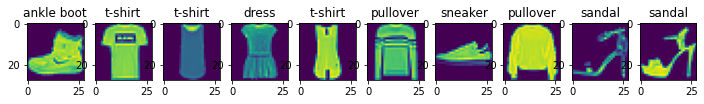

In [33]:
# 绘制图像和标签
from matplotlib import pyplot as plt

def show_fashion_mnist(images, labels):
    _, figs = plt.subplots(1, len(images), figsize=(12, 12))
    for f, img, label in zip(figs, images, labels):
        f.imshow(img.view((28, 28)).numpy())
        f.set_title(label)

def get_fashion_mnist_label(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                    'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[i] for i in labels]

X, y = [], []
for i in range(10):
    X.append(mnist_train[i][0])
    y.append(mnist_train[i][1])
show_fashion_mnist(X, get_fashion_mnist_label(y))


In [34]:
# 读取数据
import torch
import torch.utils.data

batch_size = 256

train_iter = torch.utils.data.DataLoader(
    mnist_train, batch_size=batch_size,
    shuffle=True,
    num_workers=0       # 开启num_workers个线程
)
test_iter = torch.utils.data.DataLoader(
    mnist_test, batch_size=batch_size,
    shuffle=True,
    num_workers=0       # 开启num_workers个线程
)

import time
start = time.time()
for x, y in train_iter:
    continue
print('%.2f sec' % (time.time() - start))


5.64 sec


In [35]:
# 初始化模型参数
import numpy as np
num_inputs, num_outputs = 784, 10
w = torch.tensor(np.random.normal(0, 0.01, size=(num_inputs, num_outputs)),
                    dtype=torch.float32,
                    requires_grad=True)
b = torch.tensor(np.zeros(num_outputs), dtype=torch.float32, requires_grad=True)

In [36]:
# 定义softmax函数
def softmax(y):
    y = torch.exp(y)
    return y / y.sum(dim=1, keepdim=True)

x = torch.tensor(np.random.normal(0, 0.01, size=(2, 5)), dtype=torch.float32)
x_softmax = softmax(x)
x_softmax, x_softmax.sum(dim=1)

(tensor([[0.1982, 0.2000, 0.2005, 0.2009, 0.2003],
         [0.2046, 0.1976, 0.1973, 0.1997, 0.2008]]),
 tensor([1., 1.]))

In [37]:
# 定义模型和损失函数(交叉熵)
def network(x):
    y = x.view((-1, w.shape[0])) @ w + b
    return softmax(y)

def cross_entropy(y_hat, y):
    return -torch.log(y_hat.gather(dim = 1, index = y.view(-1, 1)))

def sgd(params, lr, batch_size):
    for param in params:
        param.data -= param.grad * lr / batch_size

In [38]:
# 计算分类准确率
def accuracy(y_hat, y):
    return (y_hat.argmax() == y).float().mean().item()

def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for x, y in data_iter:
        acc_sum += (net(x).argmax(dim = 1) == y).float().sum().item()
        n += y.shape[0]
    return acc_sum / n

print(evaluate_accuracy(test_iter, network))

0.0721


In [40]:
# 训练模型
epochs, lr = 5, 0.1
def train(net, train_iter, test_iter, loss, epochs, batch_size, params, lr):
    for epoch in range(epochs):
        train_loss_sum, train_acc_sum, n = 0.0, 0.0, 0
        for x, y in train_iter:
            y_hat = net(x)
            l = loss(y_hat, y).sum()

            l.backward()
            sgd(params, lr, batch_size)

            for param in params:
                param.grad.data.zero_()
            
            train_loss_sum += l.sum().item()
            train_acc_sum += (y_hat.argmax(dim = 1) == y).sum().item()
            n += y.shape[0]
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f' %
                (epoch+1, train_loss_sum/n, train_acc_sum/n, test_acc))

train(network, train_iter, test_iter, cross_entropy, epochs, batch_size, [w, b], lr)

epoch 1, loss 0.7785, train acc 0.750, test acc 0.790
epoch 2, loss 0.5707, train acc 0.814, test acc 0.808
epoch 3, loss 0.5255, train acc 0.825, test acc 0.819
epoch 4, loss 0.5006, train acc 0.833, test acc 0.825
epoch 5, loss 0.4857, train acc 0.836, test acc 0.825
